
### MARKETING MACHINE							NEW

All up-system workflow
The centralized place for kicking off work/projects

The Marketing Machine is a new capability that centralizes user workflow management, user inputs, project execution, and integration with other subsystems like the Messaging Engine. 

The Messaging Engine will be integrated into the Command Center to allow easy user initiation of new tasks, projects, or workflows. 

We want the Marketing Machine user experience to be conversational, collaborative, easy. The system asks some questions, helps guide the user, and then kicks off the appropriate workflow to accomplish what the user wants to accomplish. 

Think of it like a Sappington consultant is collaborating with a marketing client. We’re smart, knowledgeable, warm, and proactive. That’s the experience we want to create.



In [2]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from typing import Annotated
from langgraph.graph.message import add_messages
import os
import getpass

In [3]:
llm = init_chat_model("openai:gpt-4.1")

In [4]:
context ="""Feature Description:

MARKETING MACHINE

All up-system workflow
The centralized place for kicking off work/projects

The Marketing Machine is a new capability that centralizes user workflow management, user inputs, project execution, and integration with other subsystems like the Messaging Engine. 

The Messaging Engine will be integrated into the Command Center to allow easy user initiation of new tasks, projects, or workflows. 

We want the Marketing Machine user experience to be conversational, collaborative, easy. The system asks some questions, helps guide the user, and then kicks off the appropriate workflow to accomplish what the user wants to accomplish. 

Think of it like a Sappington consultant is collaborating with a marketing client. We’re smart, knowledgeable, warm, and proactive. That’s the experience we want to create.

The possible flows are:
 
1. Outcome Engine:
The Outcome Engine is a deep research agent that accesses both publicly available information (e.g., websites) and information provided by the user to provide research on the following topics:
Companies
Industries
Audiences
Actual person (e.g., the CIO of Bank of America)

2. Messaging Engine

3. Competition Engine
We envision the Competition Engine (new name for competitive analysis) as an agent that is capable of doing competitive research and analysis based on user parameters, as well as being capable of performing recurring competitive research based on user parameters

4. Content Engine
The Content Engine represents a critical element of the entire system: Where and how content and marketing materials get created. 
the first version of Content Engine for the 1.3/launch release. For this initial version, we need to figure out:
Deliverable templates
Integration of content from the system 
Design of the deliverable with content
Ability for user to edit/manipulate content 
Ability for user to export to the appropriate format

In addition to the messaging framework document export, we will want to add at least another template format. We are thinking that we will use this content template for our first deliverable. We’re also interested in if we could include another format template.
 




"""

In [ ]:
from typing import Dict
from langchain_core.tools import tool

def greeting_agent_prompt(routes: Dict[str, str]) -> str: 
    return f"""
    You are an agent in an online store. 
    You are part of a team of other agent that can perform more specialized tasks.
    You are the first in the chain of agents. 
    You goal is to greet the customer and identify their needs.
    Once you understand the user question use tools to redirect the user the specialized agent.
    
    There are following assistants that you can redirect to:
    {''.join([f"- {key}: {value} " for key, value in routes.items()])}
        
    examples:
        user: Hello
        agent: Hello. I'm automated assistant. How can I help you? 
        user: I'd like to open an account
        tool_call: redirect_tool
    """

@tool(parse_docstring=True, response_format="content_and_artifact")
def redirect_tool(
    next_agent: str, 
) -> dict:
    """A tool that redirects to a specific agent.
    
    Args:
        next_agent: Name of the agent to redirect to.
    """
    return f"You will be redirected to {next_agent}", {'current_route': next_agent}

In [ ]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from create_agent import create_tool_calling_agent
from greeting_agent import greeting_agent_prompt, redirect_tool
from sign_up_agent import sign_up_prompt, sign_up_tool
from report_agent import report_agent_prompt, save_report_tool
from langgraph.graph import MessagesState
from langgraph.prebuilt import create_react_agent

GREETING_AGENT = "Greeting_Agent"
OUTCOME_ENGINE = "Outcome_Engine"
MESSAGING_ENGINE = "Messaging_Engine"
COMPETITION_ENGINE = "Competition_Engine"
CONTENT_ENGINE = "Content_Engine"

# Define the agent state to track the conversation
class AgentState(MessagesState):
    current_route: str
    first_name: str
    last_name: str
    email: str
    reports: list[str]

# Routs to the last used agent.
def pre_greeting_routing (default_route: str):
    def routing (state:AgentState) -> str :
        # Route to the last used agent, if it exists in the state
        if 'current_route' in state and state['current_route']:
            print("Routing to " + state['current_route'])
            return state['current_route']
        else:
            # Default to the Greeting Agent if no last agent is found
            return default_route
    
    return routing

# Routes to a new selected agent.
def post_greeting_routing (default_route: str):
    def routing (state:AgentState) -> str :
        # if current agent is greeting, route to the END
        if 'current_route' not in state or state['current_route'] == GREETING_AGENT:
            return default_route
        elif 'current_route' in state and state['current_route']:
            print("Routing to " + state['current_route'])
            return state['current_route']

    return routing

llm = ChatOpenAI(model="gpt-4o")

sign_up_agent = create_react_agent(llm, sign_up_prompt, SIGN_UP_AGENT, [sign_up_tool(GREETING_AGENT)])
sign_up_agent = create_tool_calling_agent(llm, sign_up_prompt, SIGN_UP_AGENT, [sign_up_tool(GREETING_AGENT)])
report_agent = create_tool_calling_agent(llm, report_agent_prompt, REPORT_AGENT, [save_report_tool(GREETING_AGENT)])

greeting_agent = create_tool_calling_agent(llm, greeting_agent_prompt(
    {   
        SIGN_UP_AGENT: "Can open an account for the user.",
        REPORT_AGENT: "Can report an issue.",
    }
), GREETING_AGENT, [redirect_tool], call_after_tool=False) 

# Build graph
builder = StateGraph(AgentState)
builder.add_conditional_edges(
    START,
    pre_greeting_routing(GREETING_AGENT),
)

builder.add_node(GREETING_AGENT, greeting_agent)
builder.add_conditional_edges(
    GREETING_AGENT,
    post_greeting_routing(END),
)

builder.add_node(SIGN_UP_AGENT, sign_up_agent)
builder.add_node(REPORT_AGENT, report_agent)
builder.add_edge(SIGN_UP_AGENT, END)
builder.add_edge(REPORT_AGENT, END)

memory = MemorySaver()
# Compile graph
graph = builder.compile(checkpointer=memory)

#### Try 2:

In [7]:
llm = init_chat_model("openai:gpt-4.1")

# 2. Define the routing schema
class Route(BaseModel):
    step: Literal[
        "Outcome Engine",
        "Messaging Engine",
        "Competition Engine",
        "Content Engine",
        "get_info_from_user"
    ] = Field(None, description="The next step in the routing process")

# 3. Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]
    decision: str
    output: str
    missing_info_question: str # Added to store the question for the user


# 5. Node functions
def outcome_engine(state: State):
    #result = llm.invoke(state["input"])
    result = "Outcome Engine"
    return {"output": result}

def messaging_engine(state: State):
    #result = llm.invoke(state["input"])
    result = "Messaging Engine"
    return {"output": result}

def competition_engine(state: State):
    #result = llm.invoke(state["input"])
    result = "Competition Engine"
    return {"output": result}

def content_engine(state: State):
    #result = llm.invoke(state["input"])
    result = "Content Engine"
    return {"output": result}


def get_info_from_user(state: State):
    print("--- ❓ ENTERING GET INFO ---")
    
    question = state.get("missing_info_question", "I need more information.")
    print(f"Outputting question: '{question}'")

    return {"output": question}

def marketing_machine_router(state: State):
    print("\n--- 🕵️ ENTERING ROUTER ---")
    print(f"Current Messages: {state['messages']}")

    decision = router.invoke([
        SystemMessage(content=f"Route the input to the correct node..."),
        HumanMessage(content=state["messages"][-1].content), # Pass only the latest message for decision
    ])
    
    print(f"Router Decision: '{decision.step}'")
    
    missing_info_question = ""
    if decision.step == "get_info_from_user":
        missing_info_question = "What specifically are you trying to achieve or provide more details about?"

    return {"decision": decision.step, "missing_info_question": missing_info_question}

# 6. Routing logic
def route_decision(state: State):
    # Map the decision to the correct node
    if state["decision"] == "Outcome Engine":
        return "outcome_engine"
    elif state["decision"] == "Messaging Engine":
        return "messaging_engine"
    elif state["decision"] == "Competition Engine":
        return "competition_engine"
    elif state["decision"] == "Content Engine":
        return "content_engine"
    elif state["decision"] == "get_info_from_user":
        return "get_info_from_user"
    else:
        return "get_info_from_user" # Default fallback

# 7. Build the workflow
graph = StateGraph(State)
graph.add_node("outcome_engine", outcome_engine)
graph.add_node("messaging_engine", messaging_engine)
graph.add_node("competition_engine", competition_engine)
graph.add_node("content_engine", content_engine)
graph.add_node("marketing_machine_router", marketing_machine_router)
graph.add_node("get_info_from_user", get_info_from_user)

# The graph always starts at the router
graph.add_edge(START, "marketing_machine_router")

# 💡 This is the main routing logic. After the router runs, it uses the
# 'decision' in the state to move to the correct next node.
graph.add_conditional_edges(
    "marketing_machine_router",  # <-- Source node is the router
    route_decision,              # <-- The function that reads the decision
    {
        "outcome_engine": "outcome_engine",
        "messaging_engine": "messaging_engine",
        "competition_engine": "competition_engine",
        "content_engine": "content_engine",
        "get_info_from_user": "get_info_from_user",
    },
)

# After we ask the user for more info, we loop back to the router
# to re-evaluate with the new information in the state.
graph.add_edge("get_info_from_user", "marketing_machine_router")

# The engine nodes are terminal states in this graph
graph.add_edge("outcome_engine", END)
graph.add_edge("messaging_engine", END)
graph.add_edge("competition_engine", END)
graph.add_edge("content_engine", END)

# 8. Compile the workflow
app = graph.compile()

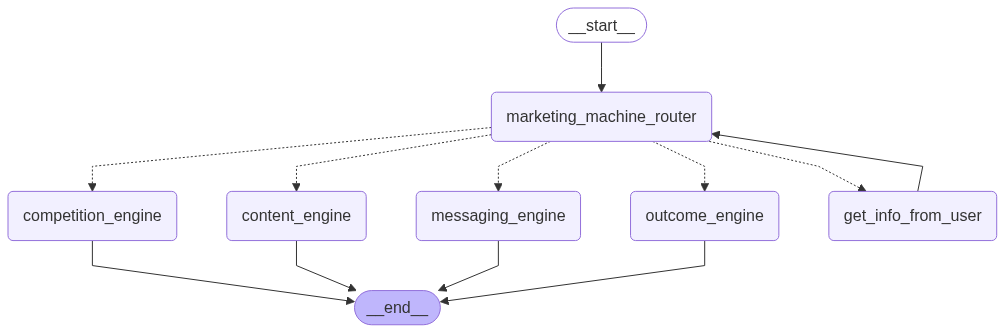

In [8]:
# Show the workflow
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
import uuid

# This is the 'app' compiled from your graph
# app = graph.compile() 

# Use a unique ID to track the conversation state
%debug
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Exiting...")
        break
        
    # The input to the graph is a dictionary with a "messages" key
    events = app.stream(
        {"messages": [HumanMessage(content=user_input)]}, 
        config=config
    )
    
    # stream() yields all state changes; the final one has the answer
    for event in events:
        if "get_info_from_user" in event:
            # The 'output' from this node is the question for the user
            print("AI:", event["get_info_from_user"]["output"])
        elif "__end__" in event:
            # When the graph finishes at an engine, print its final output
            final_state = event["__end__"]
            print("AI:", final_state["output"])

ERROR:root:No traceback has been produced, nothing to debug.
